# MNIST Reconstruction with Bernoulli Restricted Boltzmann Machines (RBM)

In [1]:
import tensorflow as tf
import os 
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
from tqdm import tqdm
import matplotlib.pyplot as plt

from rbm import RBM, sample

## Initialize RBM

In [2]:
# MNIST dataset
mnist = input_data.read_data_sets('MNIST_data', one_hot = True)

# Initialize RBM Model for MNIST reconstruction
rbm_model = RBM(n_visible = 784, n_hidden = 144, lr = tf.constant(0.05, tf.float32), epochs = 10000, mode='bernoulli')
#rbm_model = RBM(n_visible = 784, n_hidden = 144, lr = tf.constant(0.003, tf.float32), epochs = 10000, mode='gaussian')

# Placeholder for the visible layer of the RBM computation graph.
v = tf.placeholder(tf.float32, shape=[None, rbm_model.n_visible], name="visible_layer")

Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz


## Update parameters w/ K-step Contrastive Divergence using Gibbs sampling

In [3]:
# Update rule
k=1
train_op = rbm_model.update(v, K=k)

## Misc

In [4]:
# Free energy
energy = rbm_model.free_energy(v=v)
tf.summary.scalar('free_energy', tf.reduce_mean(energy))

# Merge summaries for Tensorboard visualization
summary = tf.summary.merge_all()

# Save & restore all the variables.
saver = tf.train.Saver({"weights":rbm_model.W, "visible_bias":rbm_model.vb, "hidden_bias":rbm_model.hb})

## Launch session

In [5]:
# Create session.
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
test_writer = tf.summary.FileWriter(os.getcwd()+'/RBM_logs/MNIST_Bernoulli',sess.graph)

## Train model

In [ ]:
for epoch in tqdm(range(rbm_model.epochs)):
    if epoch % 100 == 0:
        result = sess.run([rbm_model.rec_error, summary], feed_dict = {v: mnist.test.images})
        if epoch % 1000 == 0: print("Reconstruction error at step {}: {:.3f}".format(epoch, result[0]))
        test_writer.add_summary(result[1],epoch)

    batchXs, batchYs = mnist.train.next_batch(32)
    sess.run(train_op, feed_dict = {v: batchXs})

save_path = saver.save(sess, os.getcwd()+"/saved_model/actor.ckpt")
print("Saving model at: %s"%(save_path))

## Visualize hidden features

In [7]:
def plot_features(ft_map):
    """ Plot MNIST features in a table."""
    len_ = int(np.sqrt(rbm_model.n_hidden))
    fig = plt.figure()
    features = [ft_map[k] for k in range(rbm_model.n_hidden)]
    for x in range(len_):
        for y in range(len_):
            ax = fig.add_subplot(len_, len_, len_*y+x+1)
            ax.matshow(features[len_*y+x].reshape((28,28)), cmap = plt.cm.gray)
            plt.xticks(np.array([]))
            plt.yticks(np.array([]))
    plt.show()

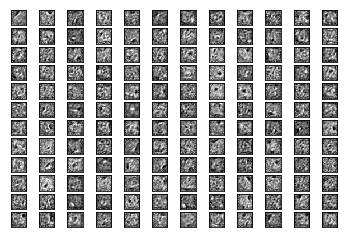

In [8]:
ft_map = sess.run(rbm_model.get_feature_map())
plot_features(ft_map)

## Test the RBM for one sample step

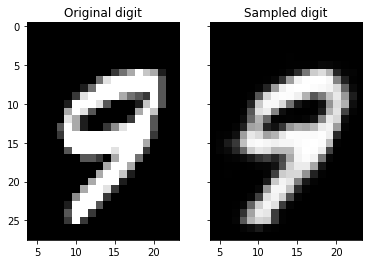

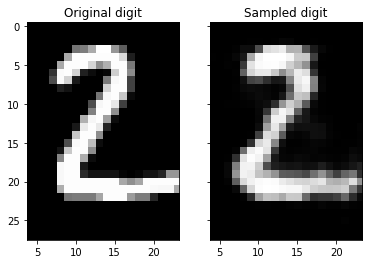

In [9]:
def show_digit(original, fake):
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    ax1.imshow(original.reshape((28,28)),cmap = plt.cm.gray)
    ax1.set_title('Original digit')
    ax2.imshow(fake.reshape((28,28)),cmap = plt.cm.gray)
    ax2.set_title('Sampled digit')
    plt.show()

train_image = mnist.train.images[1] # from train distribution
sample_train = rbm_model.gibbs(1, v=v).eval(session=sess, feed_dict={v: train_image.reshape(1,-1).astype(np.float32)})  
show_digit(original=train_image, fake=sample_train)  

test_image = mnist.test.images[1] # from test distribution
sample_test = rbm_model.gibbs(1, v=v).eval(session=sess, feed_dict={v: test_image.reshape(1,-1).astype(np.float32)})    
show_digit(original=test_image, fake=sample_test)  

tf.reset_default_graph()